✅ Datos cargados correctamente: 14148 filas y 33 columnas
🔤 Columnas categóricas: 18
🔢 Columnas numéricas: 13

📋 Promedio de Score por C del Crédito:
Carácter_score       1.911146
Capacidad_score      1.372826
Capital_score        3.028885
Condiciones_score    3.381091
Colateral_score      1.050373
dtype: float64

📊 Distribución por categoría de riesgo:
categoria_riesgo
🟡 Riesgo moderado    11696
🟠 Alto riesgo         2452
Name: count, dtype: int64


/tmp/ipykernel_6599/3124640717.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promedios_c.values, y=promedios_c.index, palette='viridis')


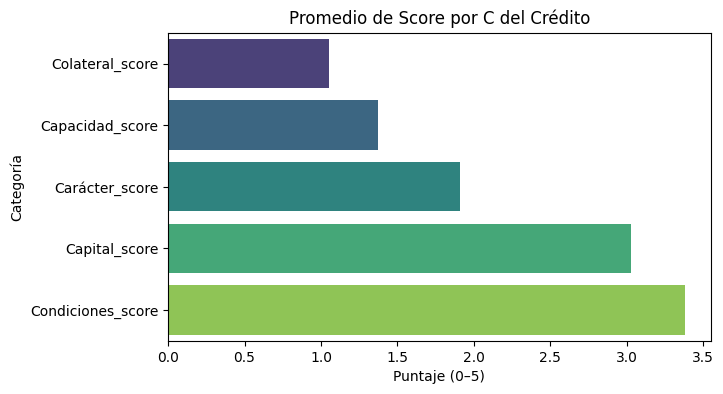

/tmp/ipykernel_6599/3124640717.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_norm['categoria_riesgo'], palette='RdYlGn', order=df_norm['categoria_riesgo'].value_counts().index)
/home/emelchor/Documentos/ProyectoLachao/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/emelchor/Documentos/ProyectoLachao/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


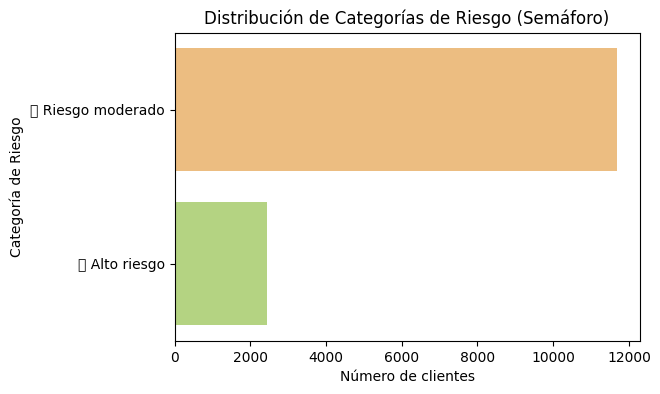


✅ Archivo 'analisis_5Cs_normalizado.csv' generado correctamente.


In [1]:
# ============================================================
# 📊 Análisis de las 5 C’s del Crédito con Normalización y Semáforo
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

# === 1️⃣ Cargar datos ===
ruta = "./../Registros_sin_nulos.csv"   # <-- ajusta la ruta si es necesario
df = pd.read_csv(ruta)

print(f"✅ Datos cargados correctamente: {df.shape[0]} filas y {df.shape[1]} columnas")

# === 2️⃣ Crear variable target ===
# Moroso (1) si diasmora > 7, caso contrario no moroso (0)
df["target"] = df["diasmora"].apply(lambda x: 1 if x > 7 else 0)

# Eliminar columnas no útiles
df = df.drop(columns=["nosocio", "nocredito", "sucursal"], errors="ignore")

# === 3️⃣ Definir las 5 C's ===
five_cs = {
    "Carácter": ["reputación_localidad", "exp_cred_externa", "exp_cred_interna", "renovadoestructurado"],
    "Capacidad": ["ingresos_ordinarios", "num_dependientes", "cap_pago", "empleo"],
    "Capital": ["monto", "tasaordinaria", "tasamoratoria", "deudas"],
    "Condiciones": ["producto", "clasificacion", "comercio_en_region", "permiso_para_funcionar", "plazocredito", "frecuenciacapint"],
    "Colateral": ["montogarantialiq", "montogarantiapre", "montogarantiahipo"]
}

# === 4️⃣ Detectar tipos de datos ===
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(exclude=['object']).columns.tolist()

print(f"🔤 Columnas categóricas: {len(cat_cols)}")
print(f"🔢 Columnas numéricas: {len(num_cols)}")

# === 5️⃣ Codificar categóricas (OrdinalEncoder) ===
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
df_encoded = df.copy()

if cat_cols:
    df_encoded[cat_cols] = encoder.fit_transform(df_encoded[cat_cols].astype(str))

# === 6️⃣ Normalizar variables numéricas a rango (0–5) ===
def normalize_series(series):
    if series.max() == series.min():
        return pd.Series([2.5] * len(series))  # valor medio si no hay variación
    return 5 * (series - series.min()) / (series.max() - series.min())

df_norm = df_encoded.copy()
for col in df_encoded.columns:
    if col != 'target':
        df_norm[col] = normalize_series(df_encoded[col])

# === 7️⃣ Calcular promedios por cada C ===
for c, cols in five_cs.items():
    cols_exist = [col for col in cols if col in df_norm.columns]
    if cols_exist:
        df_norm[c + '_score'] = df_norm[cols_exist].mean(axis=1)
    else:
        df_norm[c + '_score'] = 2.5  # valor neutro si no hay columnas

# === 8️⃣ Calcular puntaje total promedio ===
df_norm['score_total'] = df_norm[[c + '_score' for c in five_cs]].mean(axis=1)

# === 9️⃣ Clasificación tipo semáforo ===
def clasificar_semaforo(score):
    if score < 1: return "🔴 Muy alto riesgo"
    elif score < 2: return "🟠 Alto riesgo"
    elif score < 3: return "🟡 Riesgo moderado"
    elif score < 4: return "🟢 Bajo riesgo"
    else: return "🟢 Muy bajo riesgo"

df_norm['categoria_riesgo'] = df_norm['score_total'].apply(clasificar_semaforo)

# === 🔟 Mostrar resumen general ===
print("\n📋 Promedio de Score por C del Crédito:")
print(df_norm[[c + '_score' for c in five_cs]].mean())

print("\n📊 Distribución por categoría de riesgo:")
print(df_norm['categoria_riesgo'].value_counts())

# === 11️⃣ Graficar resultados ===
plt.figure(figsize=(7,4))
promedios_c = df_norm[[c + '_score' for c in five_cs]].mean().sort_values()
sns.barplot(x=promedios_c.values, y=promedios_c.index, palette='viridis')
plt.title('Promedio de Score por C del Crédito')
plt.xlabel('Puntaje (0–5)')
plt.ylabel('Categoría')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(y=df_norm['categoria_riesgo'], palette='RdYlGn', order=df_norm['categoria_riesgo'].value_counts().index)
plt.title('Distribución de Categorías de Riesgo (Semáforo)')
plt.xlabel('Número de clientes')
plt.ylabel('Categoría de Riesgo')
plt.show()

# === 12️⃣ Guardar resultados ===
df_norm.to_csv("./analisis_5Cs_normalizado.csv", index=False)
print("\n✅ Archivo 'analisis_5Cs_normalizado.csv' generado correctamente.")
